In [1]:
import sys
import os

current_notebook_dir = os.path.dirname(os.path.abspath('__file__'))
project_root_dir = os.path.abspath(os.path.join(current_notebook_dir, '../../'))

# 将这个父目录添加到sys.path的最前面
if project_root_dir not in sys.path:
    sys.path.insert(0, project_root_dir)

print(sys.path)

['/home/hqdeng7/lijuyang/generalization/loss_distribution', '/home/hqdeng7/.conda/envs/ljy/lib/python311.zip', '/home/hqdeng7/.conda/envs/ljy/lib/python3.11', '/home/hqdeng7/.conda/envs/ljy/lib/python3.11/lib-dynload', '', '/home/hqdeng7/.conda/envs/ljy/lib/python3.11/site-packages']


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from pytorch_script.visual_utils import plot_acc_losses, plot_epochs_losses_distribution, plot_losses_distribution_and_contribution

In [3]:
train_accuracies = np.load('train_accuracies.npy')
test_accuracies = np.load('test_accuracies.npy')
train_losses = np.load('train_losses.npy')
test_losses = np.load('test_losses.npy')
epochs = np.load('epochs.npy')

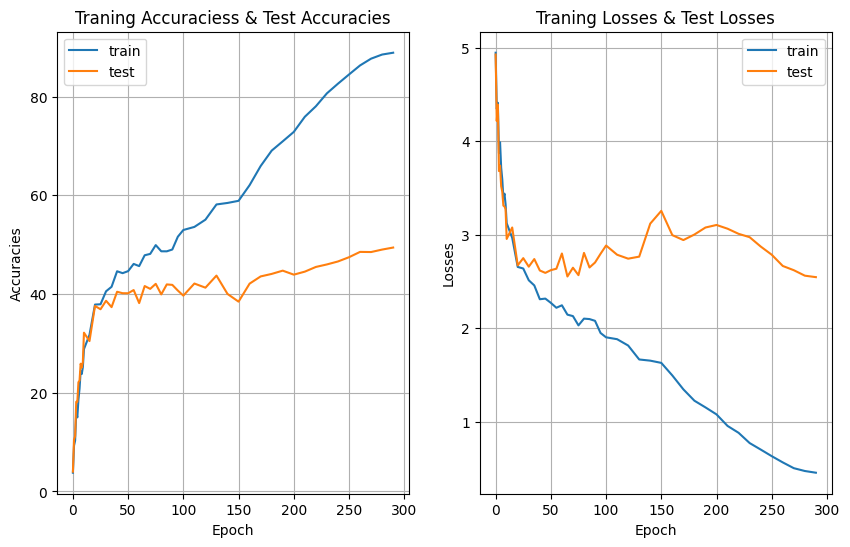

In [4]:
plot_acc_losses(epochs, train_accuracies, test_accuracies, train_losses, test_losses)

In [5]:
import pickle
with open('all_model_train_losses.pickle', 'rb') as f: 
	all_model_train_losses = pickle.load(f)

with open('all_model_test_losses.pickle', 'rb') as f: 
	all_model_test_losses = pickle.load(f)

In [42]:
all_model_train_losses[0][0], all_model_test_losses[0][0]

(5.88566780090332, 4.668367862701416)

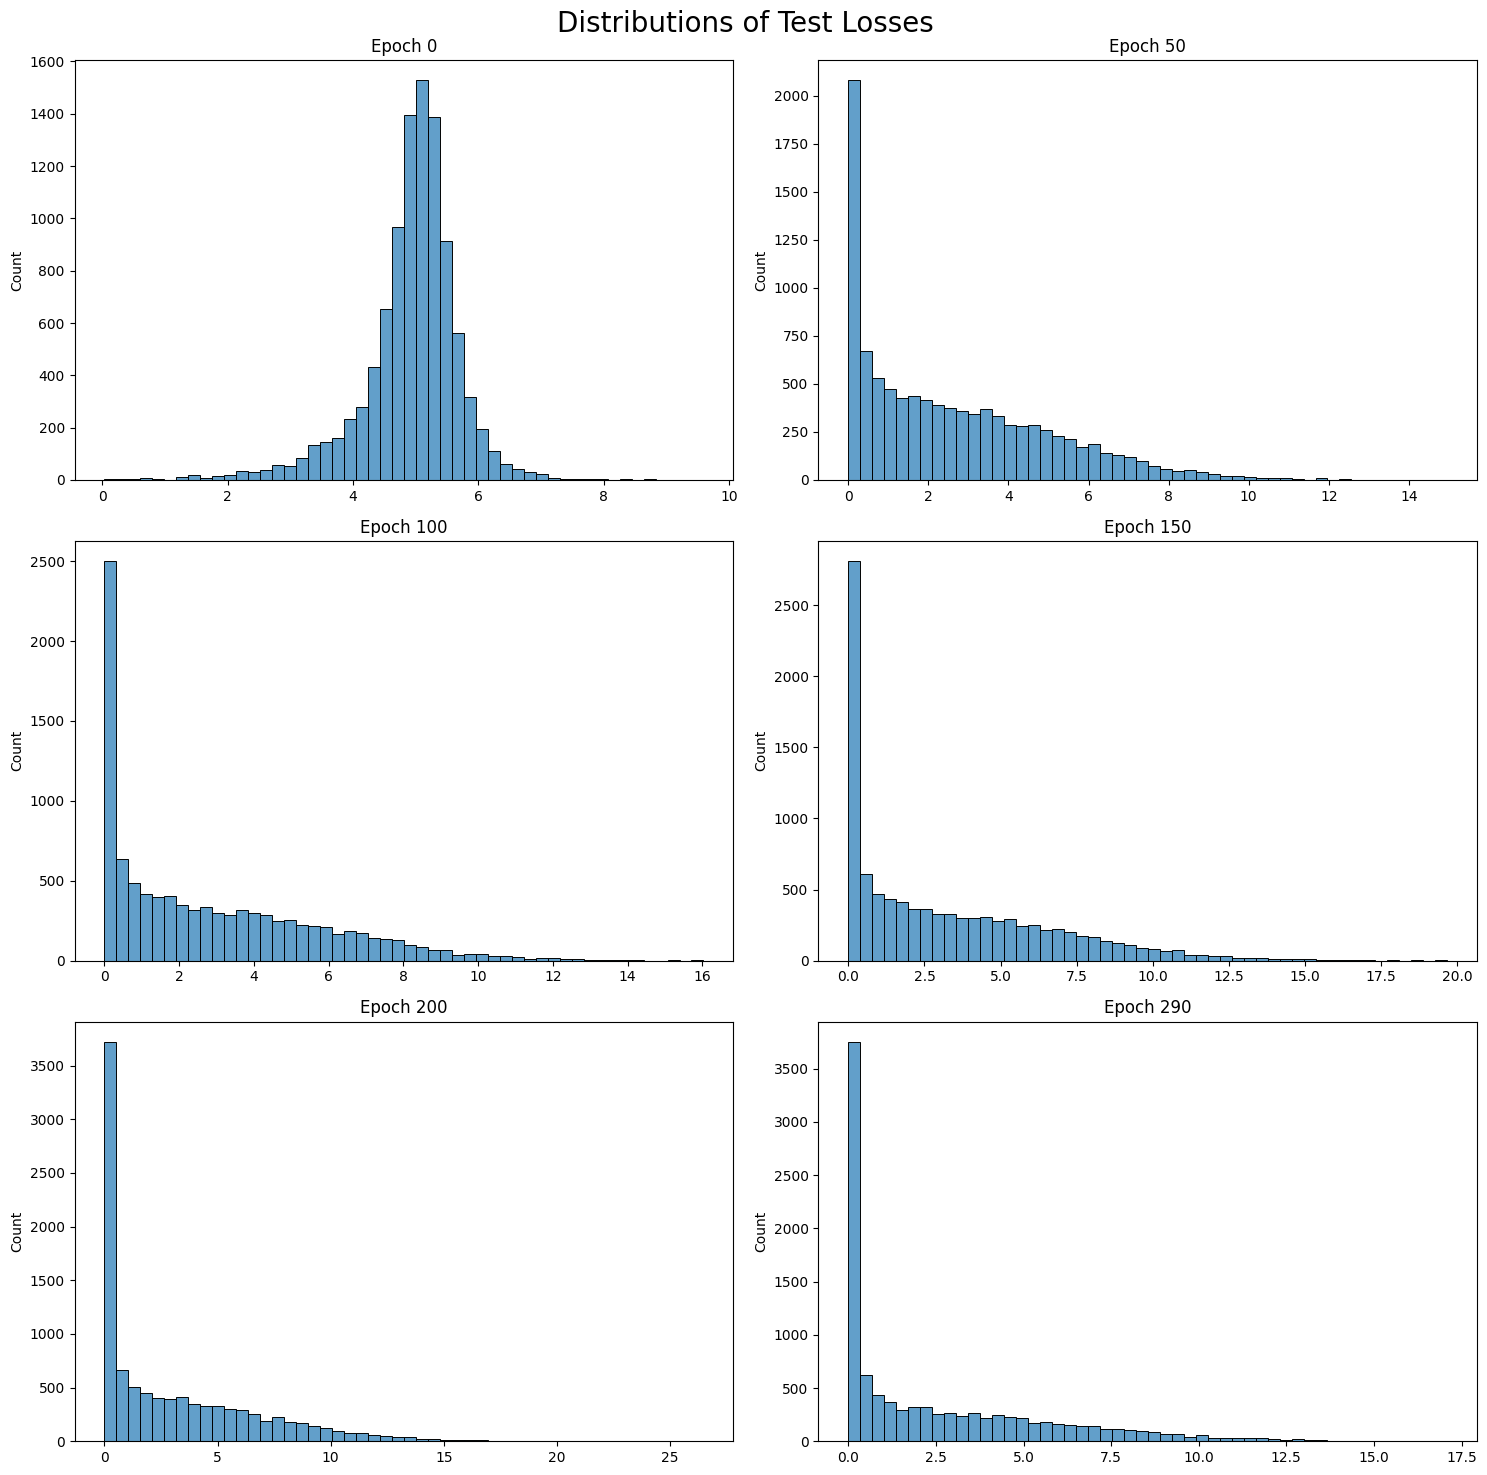

In [35]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
target_epochs = [0, 50, 100, 150, 200, 290]
for i, epoch in enumerate(target_epochs):
	epoch_losses = all_model_test_losses[epoch]
	sns.histplot(epoch_losses, kde=False, label=f'Epoch {epoch}', alpha=0.7, ax=axes[i], bins=50)
	axes[i].set_title(f"Epoch {epoch}")

fig.suptitle('Distributions of Test Losses', fontsize=20)
plt.tight_layout()

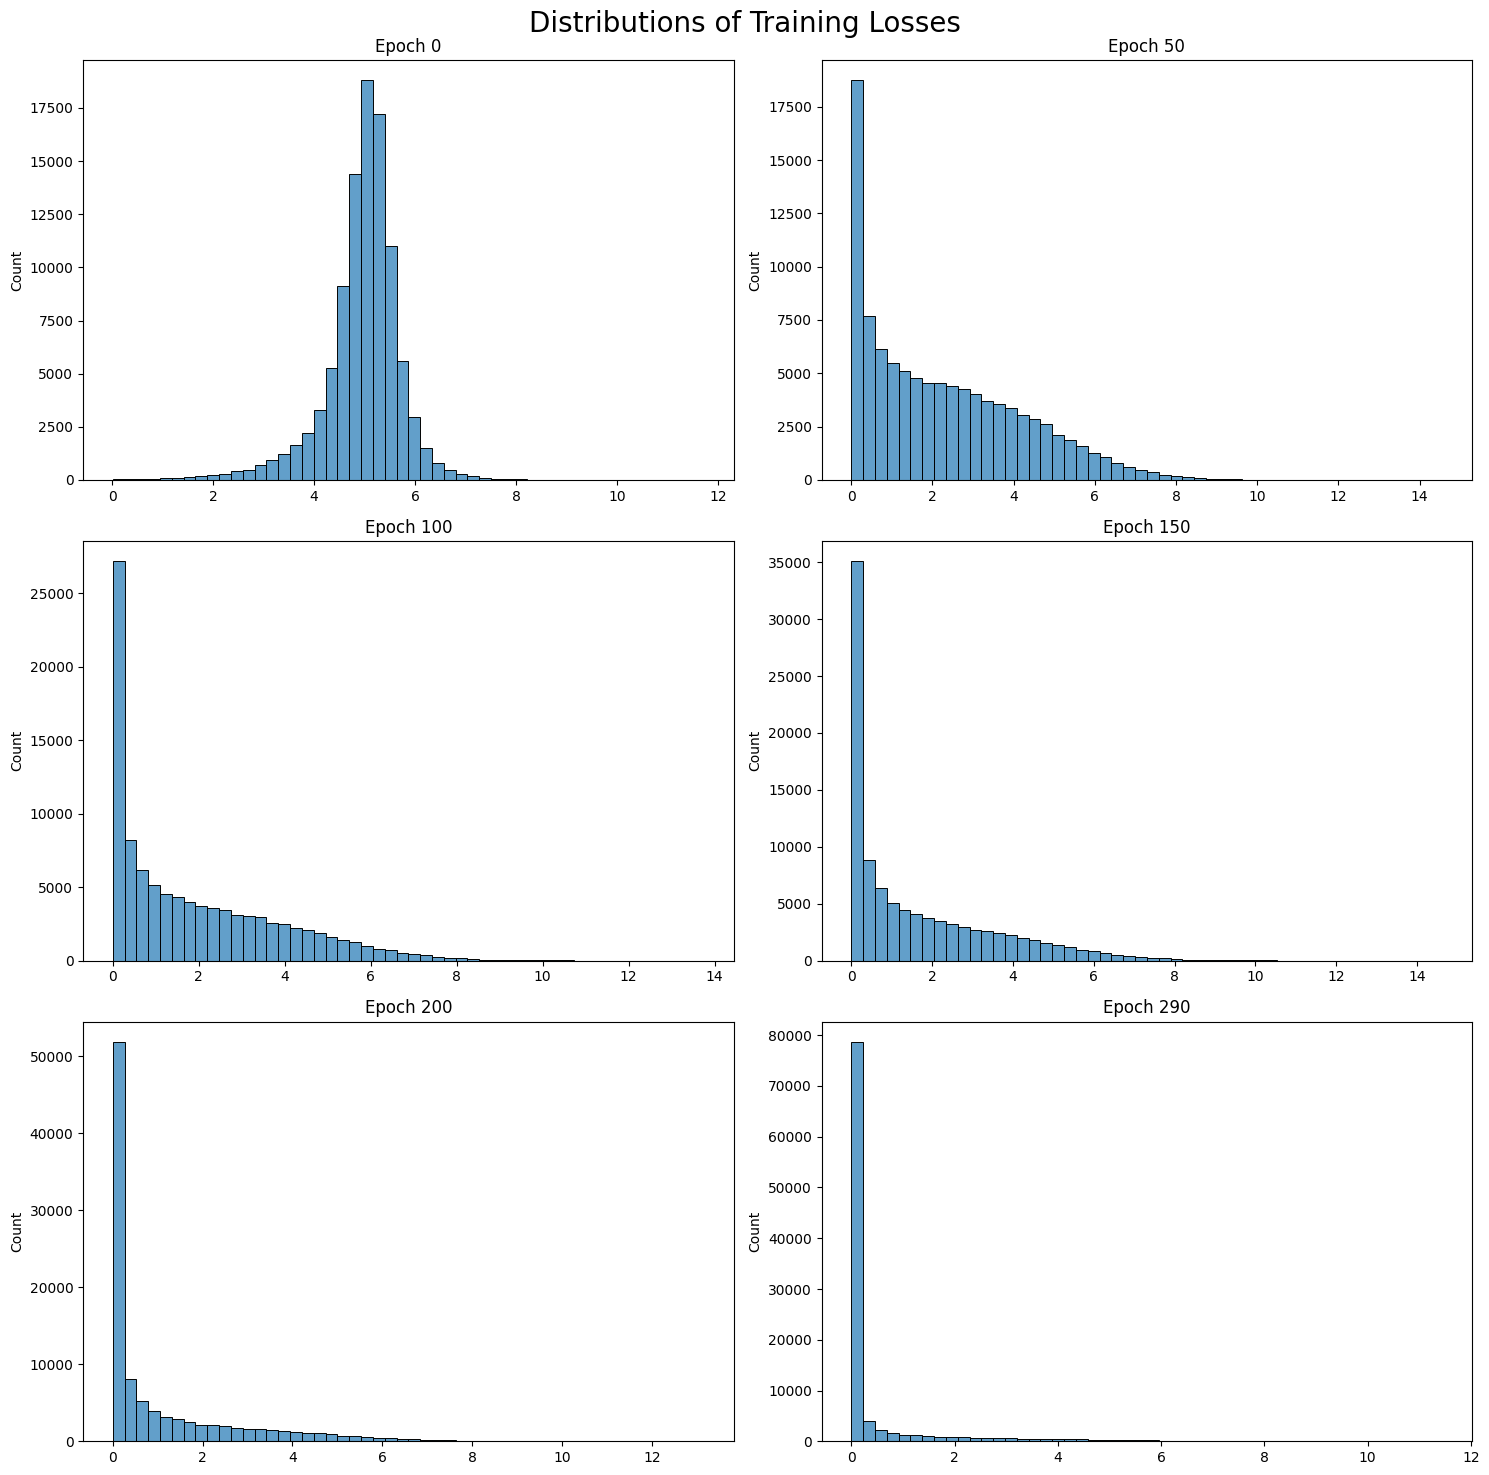

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
target_epochs = [0, 50, 100, 150, 200, 290]
for i, epoch in enumerate(target_epochs):
	epoch_losses = all_model_train_losses[epoch]
	sns.histplot(epoch_losses, kde=False, label=f'Epoch {epoch}', alpha=0.7, ax=axes[i], bins=50)
	axes[i].set_title(f"Epoch {epoch}")

fig.suptitle('Distributions of Training Losses', fontsize=20)
plt.tight_layout()

In [24]:
def _calculate_bin_sum_contributions(epoch_losses, bin_edges, total_loss):
    """
    计算每个 bin 内实际 loss 值的总和，并将其按总 loss 进行归一化。

    参数:
        epoch_losses (np.array 或 list): 当前 epoch 的 loss 值列表或数组。
        bin_edges (np.array): 来自 np.histogram 的 bin 边界。
        total_loss (float): 当前 epoch 的所有 loss 值的总和。

    返回:
        np.array: 归一化后的贡献度 (每个 bin 内实际 loss 总和 / 总 loss)。
    """
    # 初始化一个数组，用于存储每个 bin 内 loss 值的累加和
    bin_sum_losses = np.zeros(len(bin_edges) - 1)

    # 遍历每个 loss，将其累加到正确的 bin 中
    for loss in epoch_losses:
        # np.digitize 返回每个值所属 bin 的索引。
        # 结果是 1-based index，对于等于最后一个 bin 边界的值，返回 len(bin_edges)。
        # 所以需要 -1 转换为 0-based index。
        bin_idx = np.digitize(loss, bin_edges) - 1

        # 确保索引在 bin_sum_losses 的有效范围内
        # 例如，如果 loss 恰好等于最后一个 bin 的上边界，np.digitize 可能返回 len(bin_edges)。
        bin_idx = np.clip(bin_idx, 0, len(bin_sum_losses) - 1)

        bin_sum_losses[bin_idx] += loss

    # 将每个 bin 的累加和除以总 loss 进行归一化
    if total_loss == 0:
        return np.zeros_like(bin_sum_losses)
    else:
        return bin_sum_losses / total_loss


# --- 主绘图函数 ---
def plot_loss_contribution(epoch_index, epoch_losses, ax):
    """
    绘制给定 epoch 的 loss 分布 (直方图) 和每个 bin 的实际 loss 贡献度。

    参数:
        epoch_index (int): 要绘制的 epoch 索引。
        num_bins (int): 直方图的 bin 数量。
        ax (matplotlib.axes.Axes): 用于绘图的 Axes 对象。
    """
    epoch_losses = np.array(epoch_losses)
    total_loss = np.sum(epoch_losses)

    hist, bin_edges = np.histogram(epoch_losses)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # bin 的中心点，用于条形图定位
    contributions = _calculate_bin_sum_contributions(epoch_losses, bin_edges, total_loss)

    ax.bar(bin_centers, contributions, width=(bin_edges[1] - bin_edges[0]) * 0.9, color='lightcoral', edgecolor='black', label='Loss Contribution', alpha=0.7)

    ax.set_ylabel('Contribution (Loss * Frequency)', color='lightcoral') # 修改标签，更准确
    ax.tick_params(axis='y', labelcolor='lightcoral')
    ax.set_ylim(0, max(contributions) * 1.1 if len(contributions) > 0 and max(contributions) > 0 else 0.1)

    ax.set_xlabel('Loss Value')
    ax.grid(axis='y', linestyle='--', alpha=0.4) # 主轴网格线

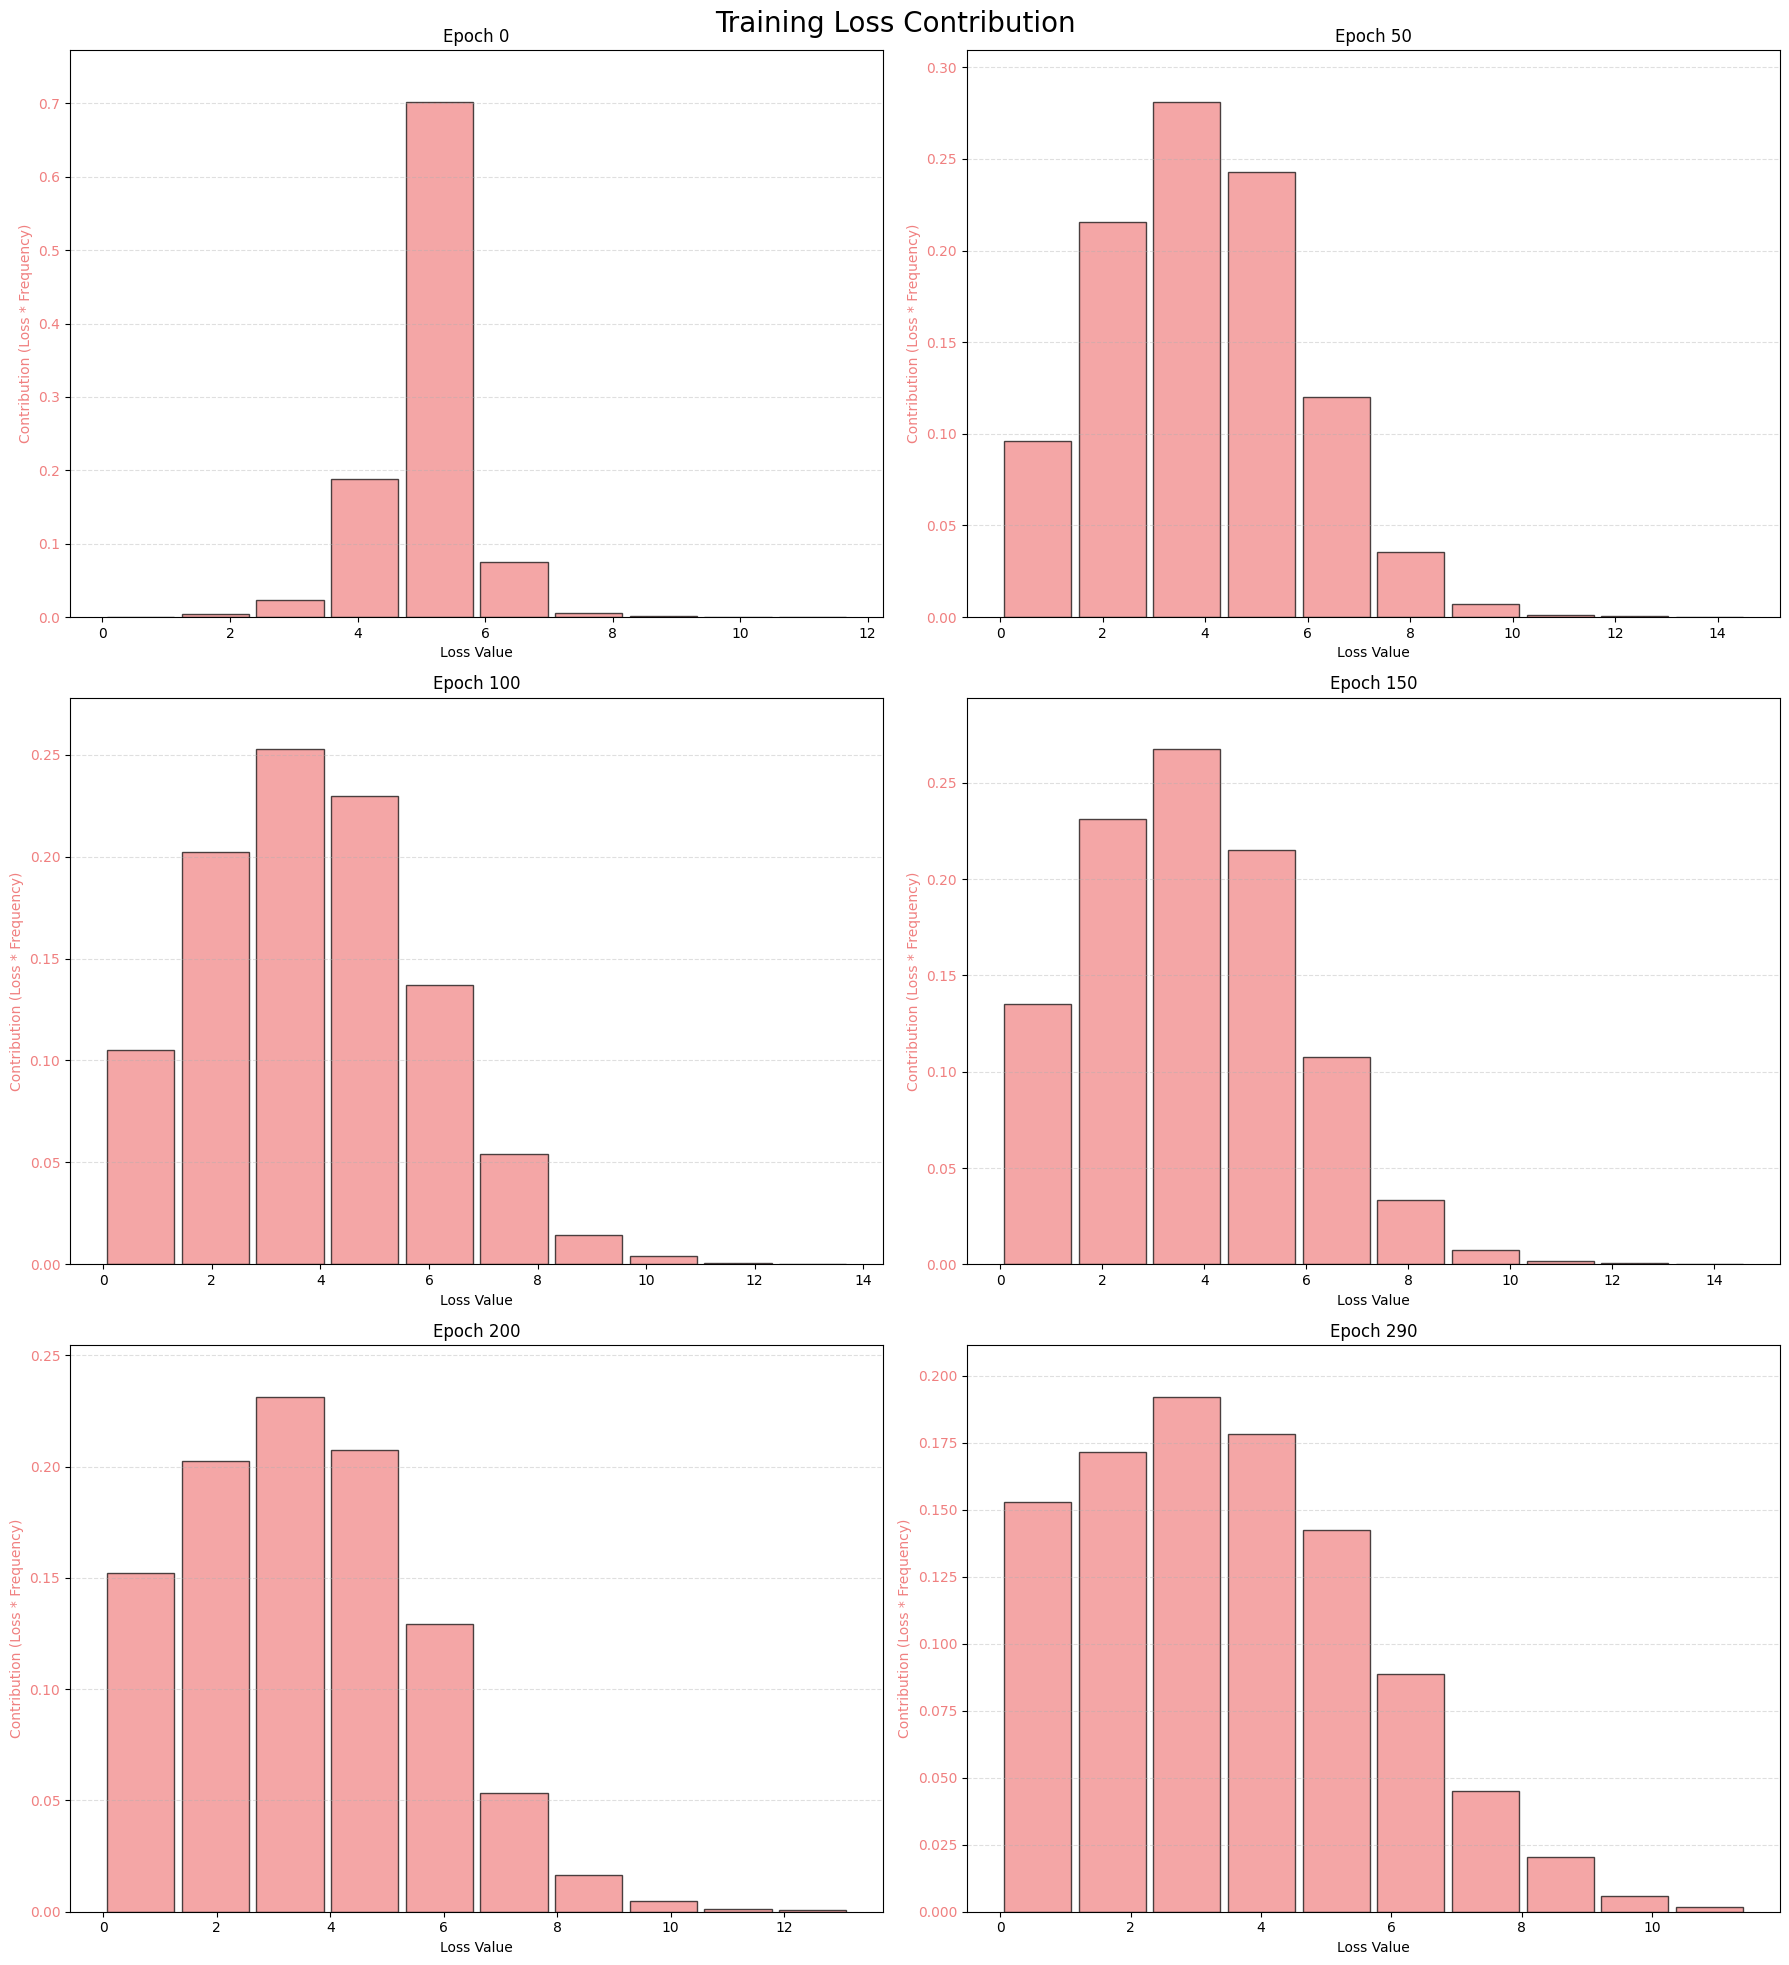

In [36]:
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()
for i, epoch in enumerate(target_epochs):
	plot_loss_contribution(epoch, all_model_train_losses[epoch], axes[i])
	axes[i].set_title(f"Epoch {epoch}")
fig.suptitle("Training Loss Contribution", fontsize=20)
plt.tight_layout()

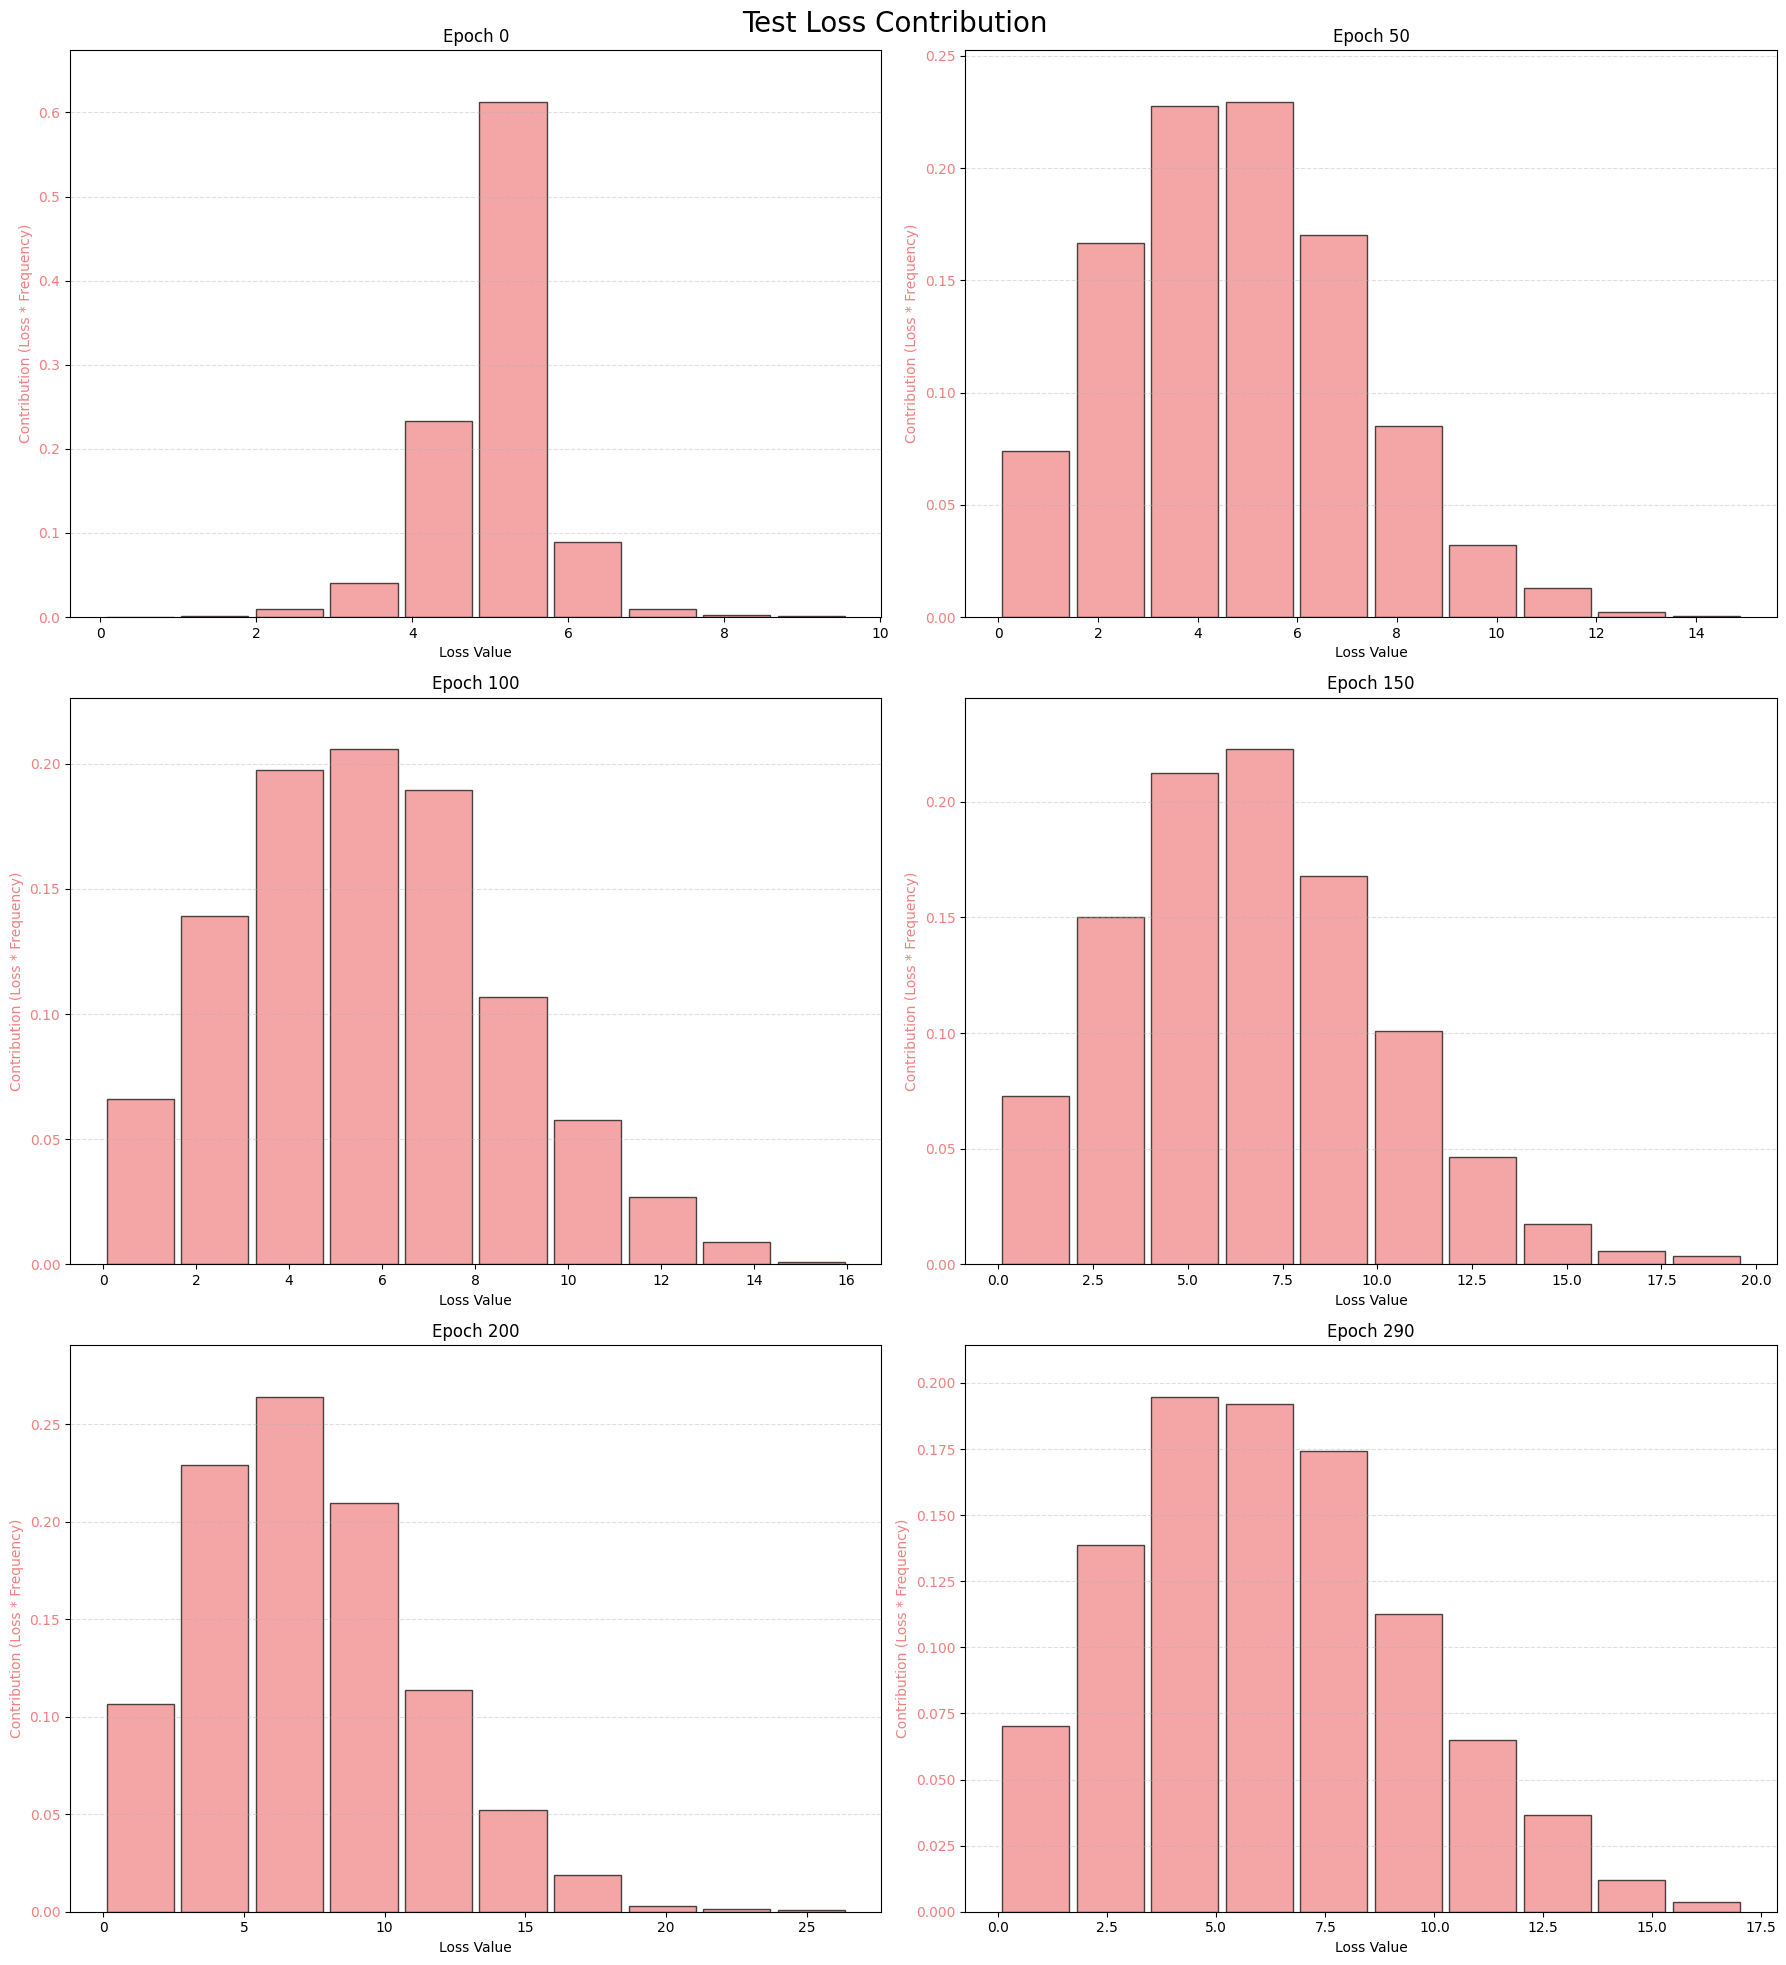

In [38]:
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()
for i, epoch in enumerate(target_epochs):
	plot_loss_contribution(epoch, all_model_test_losses[epoch], axes[i])
	axes[i].set_title(f"Epoch {epoch}")
	
fig.suptitle("Test Loss Contribution", fontsize=20)
plt.tight_layout()